In [ ]:
# !pip install segmentation-models

In [1]:
# from unet import simple_unet_model
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff

import tensorflow as tf
import pandas as pd
import glob
from sklearn.model_selection import train_test_split

In [2]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 3

In [3]:
import cv2

# Define the desired shape
def img_read(path):
    desired_shape = (IMG_WIDTH, IMG_HEIGHT)

    # Load the image
    image = cv2.imread(path,)
    img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    # Resize the image to the desired shape
    desired_size = (IMG_WIDTH, IMG_HEIGHT)



    # Convert the image to a numpy array for further processing
    return cv2.resize(img,desired_shape, interpolation=cv2.INTER_AREA)
def msk_read(path):
    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    desired_size = (IMG_WIDTH, IMG_HEIGHT)
 
    resized_image = cv2.resize(img, desired_size, interpolation=cv2.INTER_AREA)

    # Convert the image to a numpy array for further processing
    return resized_image

In [4]:
large_image_stack = []
large_mask_stack = []
import os
mask_file_names=os.listdir("Ocular_Toxoplasmosis_Data_V3\\segmentation_task\\mask_aug\\")
X=[]
y=[]

for i in mask_file_names:
    try:
        p=os.path.join("Ocular_Toxoplasmosis_Data_V3\\segmentation_task\\img_aug\\",i)
        X.append(os.path.join("Ocular_Toxoplasmosis_Data_V3\\segmentation_task\\img_aug\\",i))
        y.append(os.path.join("Ocular_Toxoplasmosis_Data_V3\\segmentation_task\\mask_aug\\",i))
        
        
    except:
        print(f'{i} does not exist in image')



for file_path in X:   
    #print('0')
    signal = img_read(file_path)/255.
    
    large_image_stack.append(signal)


for file_path in y:   
    #print('1')
    signal = msk_read(file_path)/255.
    large_mask_stack.append(signal)
   


In [5]:
large_image_stack=np.array(large_image_stack)
large_mask_stack=np.array(large_mask_stack)
large_mask_stack=np.expand_dims(large_mask_stack, -1)

In [6]:
# all_img_patches = []
# for img in range(large_image_stack.shape[0]):
#     #print(img)     #just stop here to see all file names printed
     
#     large_image = large_image_stack[img]
    
#     patches_img = patchify(large_image, (512, 512,3), step=256)  #Step=256 for 256 patches means no overlap
#     patches_img=np.squeeze(patches_img)

#     for i in range(patches_img.shape[0]):
#         for j in range(patches_img.shape[1]):
            
#             single_patch_img = patches_img[i,j,:,:]
# #             single_patch_img = single_patch_img / 255.
            
#             all_img_patches.append(single_patch_img)

In [7]:
large_image_stack.shape

(1480, 512, 512, 3)

In [8]:
# all_img_patches=np.array(all_img_patches)
# all_mask_patches=np.array(all_mask_patches)
# all_mask_patches=np.expand_dims(all_mask_patches,-1)

In [9]:
large_image_stack.shape, large_mask_stack.shape

((1480, 512, 512, 3), (1480, 512, 512, 1))

In [10]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [14]:
BACKBONE='vgg16'
preprocess_input1=sm.get_preprocessing(BACKBONE)


In [15]:
images1=preprocess_input1(large_image_stack)

In [16]:
X_train, X_test, y_train, y_test=train_test_split(images1,large_mask_stack,random_state=42, test_size=0.25)

In [17]:
X_train_g=X_train #[:,:,:,1]
X_test_g=X_test
# X_test_g=np.expand_dims(X_test[:,:,:,1],-1)

In [18]:
# X_train_g=np.zeros_like(X_train)
# X_train_g[:,:, :, 1]=X_train[:,:, :, 1]
# X_test_g=np.zeros_like(X_test)

# X_train_g[:,:, :, 1]=X_train[:,:, :, 1]
# X_test_g[:,:, :, 1]=X_test[:,:, :, 1]

In [19]:
X_train_g.shape,y_train.shape,X_test_g.shape,y_test.shape

((1110, 512, 512, 3),
 (1110, 512, 512, 1),
 (370, 512, 512, 3),
 (370, 512, 512, 1))

In [20]:
import random
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


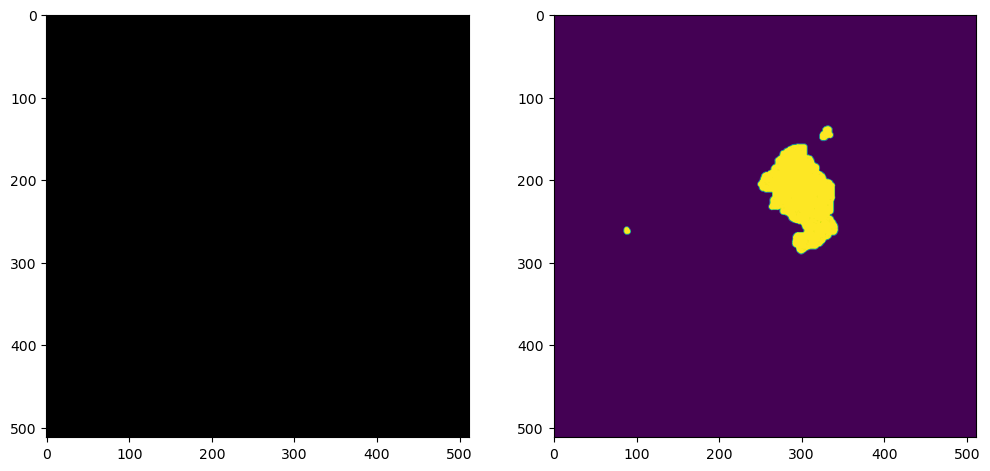

In [21]:
rng=random.randint(0,X_train_g.shape[0])
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(X_train_g[rng],cmap='gray')
plt.subplot(122)
plt.imshow(y_train[rng]);

In [ ]:
seed=24
from keras.preprocessing.image import ImageDataGenerator


# img_data_gen_args=dict(
#                       rotation_range=90,

# #                       shear_range=0.5,
#                       zoom_range=0.3,
#                       horizontal_flip=True,
#                       vertical_flip=True,
# #                       fill_mode='reflect'
#                       )


# mask_data_gen_args=dict(
#                       rotation_range=90,
#                       width_shift_range=0.3,
#                       height_shift_range=0.3,
# #                       shear_range=0.5,
#                       zoom_range=0.3,
#                       horizontal_flip=True,
#                       vertical_flip=True,
# #                       fill_mode='reflect',
#                        preprocessing_function=lambda x:np.where(x>0,1,0).astype(x.dtype))

In [ ]:
image_data_generator=ImageDataGenerator()
image_data_generator.fit(X_train,augment=False,seed=seed)

image_generator=image_data_generator.flow(X_train_g,seed=seed)
valid_img_generator=image_data_generator.flow(X_test,seed=seed)

In [ ]:
mask_data_generator=ImageDataGenerator()
mask_data_generator.fit(y_train,augment=False,seed=seed)

mask_generator=mask_data_generator.flow(y_train,seed=seed)
valid_mask_generator=mask_data_generator.flow(y_test,seed=seed)

In [ ]:
def my_image_generator(image_generator, mask_generator):
    train_generator=zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        yield (img, mask)

In [ ]:
my_generator=my_image_generator(image_generator, mask_generator)

validation_datagen=my_image_generator(valid_img_generator, valid_mask_generator)

In [ ]:
x=image_generator.next()
y=mask_generator.next()

for i in range(0,1):
    image=x[i]
    mask=y[i]
    print(image.shape)
    plt.subplot(121)
    plt.imshow(image)
    plt.subplot(122)
    plt.imshow(mask)

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    return x

In [ ]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
def build_vgg16_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)
    b1 = vgg16.get_layer("block5_conv3").output
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)   
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

In [ ]:
input_shape = (256, 256, 3)
model = build_vgg16_unet(input_shape)
model.summary()

In [ ]:
BACKBONE='vgg16'
preprocess_input1=sm.get_preprocessing(BACKBONE)
model=sm.Unet(BACKBONE,encoder_weights='imagenet')
model.compile('Adam',loss=sm.losses.bce_dice_loss,metrics=[sm.metrics.iou_score,sm.losses.bce_jaccard_loss])
model.summary()

In [ ]:
callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=5, verbose=1),
#     tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('Ocular_Toxoplasmosis_Data_V3\\segmentation_task\\working\\model-Xfer_vgg_dice_loss.h5', verbose=1, save_best_only=True, save_weights_only=True)
]
history=model.fit(my_generator,validation_data=validation_datagen,steps_per_epoch=50,validation_steps=50, epochs=100,callbacks=callbacks)

In [ ]:
model=tf.keras.models.load_model('Ocular_Toxoplasmosis_Data_V3\\segmentation_task\\working\\model-Xfer_dice_loss.h5')

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
y_pred_thresh=y_pred>0.5
intersection=np.logical_and(y_test,y_pred_thresh)
union=np.logical_or(y_test,y_pred_thresh)
iou=np.sum(intersection)/np.sum(union)
iou

In [ ]:
test_img_num=random.randint(0,len(X_test)-1)
test_img=X_test[test_img_num]
test_img_input=np.expand_dims(test_img,0)
gt=y_test[test_img_num]
yp=model.predict(test_img_input)

plt.figure(figsize=(10,7))
plt.subplot(121)
plt.imshow(yp[0,:,:,0]>.5)
plt.subplot(122)
plt.imshow(gt[:,:,0])


In [ ]:
yp.shape

In [ ]:
plt.imshow(yp[0,:,:,0])

In [ ]:
plt.imshow(gt[:,:,0])

In [ ]:
gt.shape